# Classification of Alzhaimer through Brain MRI

In [115]:
# Package imports.
import os
import cv2

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random

import tensorflow as tf
from keras.utils import to_categorical
from keras import layers
from sklearn import model_selection, metrics, preprocessing

In [116]:
# Import and mount Google Drive.
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
# Unzip the dataset file and store it in a folder called images.
#!unzip "/content/drive/MyDrive/MRI.zip" -d "/content/drive/MyDrive/images_MRI/"

In [118]:
!ls "/content/drive/MyDrive/images_MRI/Data"

'Mild Dementia'  'Moderate Dementia'  'Non Demented'  'Very mild Dementia'


In [119]:
# Read the images and get the data in a RGB and specific shape
folder_path = "/content/drive/MyDrive/images_MRI/Data/"
size = 115
data = []
labels = []
paths=[]
for folder in os.listdir(folder_path):
    for files in os.listdir(os.path.join(folder_path, folder)):
        if files.endswith("jpg"):
            labels.append(folder)
            # Create the image path.
            img_path = os.path.join(folder_path, folder, files)
            # Read in the images.
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            # Change BGR colour default from cv2 to RGB used in matplotlib.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Resize the images.
            img = cv2.resize(img, (size, size))
            data.append(img)
            paths.append(img_path)

# Convert the data from a list to a NumPy array.
data_arr = np.array(data)

## Select by random sampling

In [120]:
#labels_np=np.array(labels)
#selected_indices={}
#for t in ['Mild Dementia','Non Demented','Very mild Dementia']:
#  selected_indices[t]=np.random.choice(np.where(labels_np==t)[0],500,replace=False)
#all_indices=np.hstack((selected_indices['Mild Dementia'],selected_indices['Non Demented'],selected_indices['Very mild Dementia'],np.where(labels_np=='Moderate Dementia')[0]))
#paths_to_delete=np.setdiff1d(np.array(paths),np.array(paths)[all_indices])
#for n in paths_to_delete:
#  os.remove(n)

## Data Analysis

In [121]:
# Check the size of the images
data_arr.shape

(1988, 115, 115, 3)

In [122]:
# Check all the classes
set(labels)

{'Mild Dementia', 'Moderate Dementia', 'Non Demented', 'Very mild Dementia'}

In [123]:
#Checking number of images from Mild Dementia
print('Mild Dementia:',labels.count("Mild Dementia"))
#Checking number of images from Moderate Dementia
print('Moderate Dementia:',labels.count("Moderate Dementia"))
#Checking number of images from Non Demented
print('Non Demented:',labels.count("Non Demented"))
#Checking number of images from Very mild Dementia
print('Very mild Dementia:',labels.count("Very mild Dementia"))

Mild Dementia: 500
Moderate Dementia: 488
Non Demented: 500
Very mild Dementia: 500


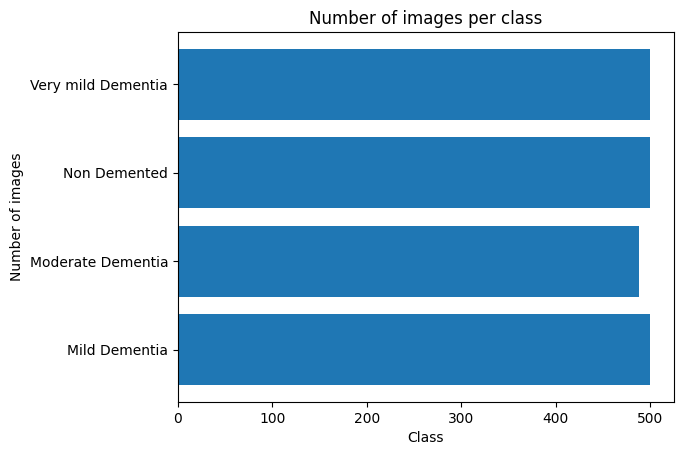

In [124]:
labels_plt=['Mild Dementia','Moderate Dementia','Non Demented','Very mild Dementia']
count=[labels.count('Mild Dementia'),labels.count('Moderate Dementia'),labels.count('Non Demented'),labels.count('Very mild Dementia')]
fig,ax=plt.subplots()
ax.barh(labels_plt,count)
ax.set_title('Number of images per class')
ax.set_xlabel('Class')
ax.set_ylabel('Number of images')
plt.show()

Text(0.5, 1.0, 'Very mild Dementia')

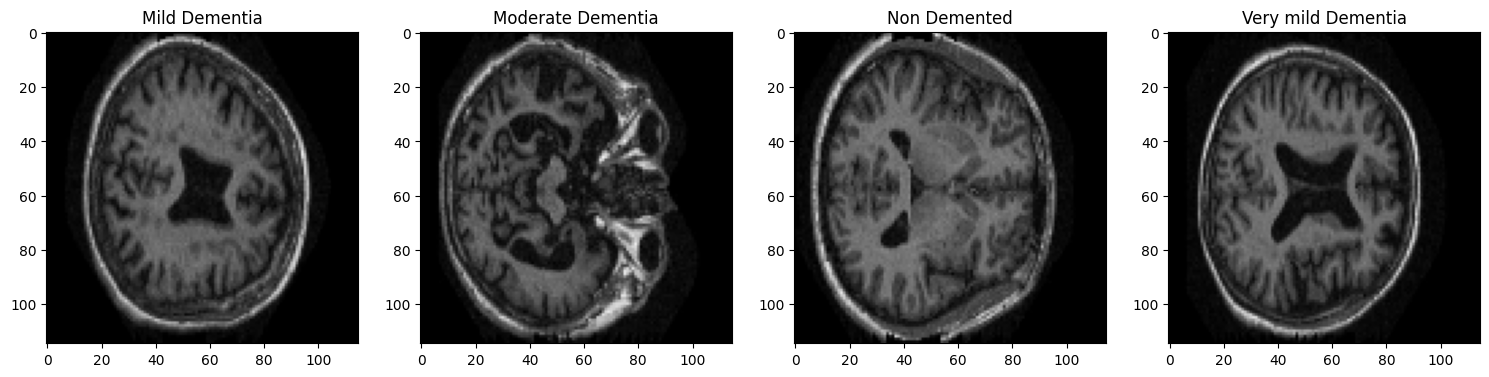

In [125]:
fig,ax=plt.subplots(1,4)
fig.set_size_inches(18.5, 10.5)
ax[0].imshow(data_arr[np.random.choice(range(1,500),1)[0]])
ax[0].set_title('Mild Dementia')
ax[1].imshow(data_arr[np.random.choice(range(501,1000),1)[0]])
ax[1].set_title('Moderate Dementia')
ax[2].imshow(data_arr[np.random.choice(range(1001,1500),1)[0]])
ax[2].set_title('Non Demented')
ax[3].imshow(data_arr[np.random.choice(range(1501,2000),1)[0]])
ax[3].set_title('Very mild Dementia')

In [126]:
#noice_percentage=0.1
#noise=np.random.normal(0,255*noice_percentage,image.shape)
#image_noise=np.clip(image+noise,0,255).astype('uint8')

## Create the noise

In [195]:
def image_noise(image,noise_level):
  height, width, channels = image.shape
  pixels_total=height*width*channels
  noise_added=int(pixels_total*noise_level)
  noise_total=0
  while noise_total<noise_added:
    w=random.randint(1,3)
    h=random.randint(1,3)
    noise_total+=w*h
    x=random.randint(0,width-w)
    y=random.randint(0,height-h)
    image[y:y+h,x:x+w,:]=np.random.randint(1,25)
  return image

In [196]:
def image_augment(image,seed):
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    image = tf.image.stateless_random_flip_left_right(
        image, seed)
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    image = tf.image.stateless_random_hue(
        image, 0.1, seed)
    image = tf.image.stateless_random_saturation(
        image, 0.5, 1.0, seed)
    image = tf.clip_by_value(image, 0, 255)
    return image

In [197]:
rng = tf.random.Generator.from_seed(123, alg='philox')

In [198]:
def image_wrapper(image):
  seed=rng.make_seeds(2)[0]
  image=image_augment(image,seed)
  image2=image_noise(image,0.07)
  return image2,image

In [199]:
data_arr[1:10].shape

(9, 115, 115, 3)

In [200]:
image_wrapper(data_arr[1])

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

# Please finish the image augmentation for the problem as well as the wrapper and noise in a single function to generate the input data of the U-net

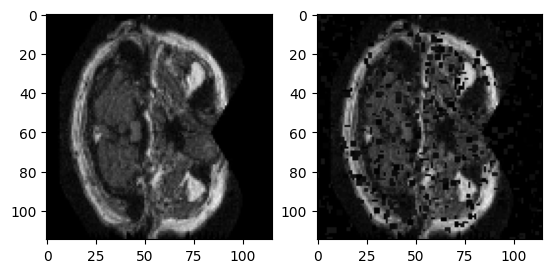

In [110]:
image1=data_arr[np.random.choice(range(501,1000),1)[0]]
fig,ax=plt.subplots(1,2)
ax[0].imshow(image1)
ax[1].imshow(image_noise(image1,0.07))